<a href="https://colab.research.google.com/github/Crltt/GCA-ROM/blob/main/notebook/14_maxelldg_TEZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install PyTorch
try:
  import torch
except ImportError:
  !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
  import torch

In [2]:
# Install PyG
try:
  import torch_geometric
except ImportError:
  !pip3 install torch_geometric
  import torch_geometric

In [3]:
# Clone and import gca-rom
#!git clone https://github.com/Crltt/GCA-ROM.git
import sys
sys.path.append('GCA-ROM')
from gca_rom_dg import network, pde, loader, plotting, preprocessing, training, initialization, testing, error, gui


In [4]:
import numpy as np
from itertools import product

# Define PDE problem
For the description of the model and generation of the dataset look at: Hesthaven, Jan & Warburton, Tim. (2007). Nodal Discontinuous Galerkin Methods: Algorithms, Analysis, and Applications (https://github.com/tcew/nodal-dg.git)

In [5]:
problem_name, variable, mu_space, n_param = pde.problem(14)
print("\nProblem: ", problem_name)
print("Variable: ", variable)
print("Parameters: ", n_param)
argv = gui.hyperparameters_selection(problem_name, variable, n_param)
HyperParams = network.HyperParams(argv)


Problem:  maxwelldg
Variable:  TEz
Parameters:  1


# Initialize device and set reproducibility

In [6]:
device = initialization.set_device()
initialization.set_reproducibility(HyperParams)
initialization.set_path(HyperParams)

Device used:  cpu


# Load dataset

In [7]:
dataset_dir = 'GCA-ROM/dataset/'+problem_name+'_unstructured.mat'
dataset = loader.LoadDataset(dataset_dir, variable)

graph_loader, train_loader, test_loader, \
    val_loader, scaler_all, scaler_test, xyz, VAR_all, VAR_test, \
        train_trajectories, test_trajectories = preprocessing.graphs_dataset(dataset, HyperParams)

params = torch.tensor(np.array(list(product(*mu_space))))
params = params.to(device)

Number of nodes processed:  146
Number of graphs processed:  336
edge index:  torch.Size([2, 434])
edge attribute:  torch.Size([434])
edge attribute:  torch.Size([434])
edge attribute:  torch.Size([434])
edge attribute:  torch.Size([434])
edge attribute:  torch.Size([434])
edge attribute:  torch.Size([434])
edge attribute:  torch.Size([434])
edge attribute:  torch.Size([434])
edge attribute:  torch.Size([434])
edge attribute:  torch.Size([434])
edge attribute:  torch.Size([434])
edge attribute:  torch.Size([434])
edge attribute:  torch.Size([434])
edge attribute:  torch.Size([434])
edge attribute:  torch.Size([434])
edge attribute:  torch.Size([434])
edge attribute:  torch.Size([434])
edge attribute:  torch.Size([434])
edge attribute:  torch.Size([434])
edge attribute:  torch.Size([434])
edge attribute:  torch.Size([434])
edge attribute:  torch.Size([434])
edge attribute:  torch.Size([434])
edge attribute:  torch.Size([434])
edge attribute:  torch.Size([434])
edge attribute:  torch.Siz

# Define the architecture

In [8]:
model = network.Net(HyperParams)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=HyperParams.learning_rate, weight_decay=HyperParams.weight_decay)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=HyperParams.miles, gamma=HyperParams.gamma)

input size:  146
hidden_channels:  3
hidden_channels:  3
input_size:  146
ffn:  200


# Train or load a pre-trained network

In [9]:
try:
    model.load_state_dict(torch.load(HyperParams.net_dir+HyperParams.net_name+HyperParams.net_run+'.pt', map_location=torch.device('cpu')))
    print('Loading saved network')
except FileNotFoundError:
    print('Training network')
    training.train(model, optimizer, device, scheduler, params, train_loader, test_loader, train_trajectories, test_trajectories, HyperParams)

Loading saved network


# Evaluate the model

In [10]:
model.to("cpu")
params = params.to("cpu")
vars = "GCA-ROM"
results, latents_map, latents_gca = testing.evaluate(VAR_all, model, graph_loader, params, HyperParams, range(params.shape[0]))

100%|██████████| 336/336 [00:04<00:00, 74.69it/s]


# Plot the results

36
43
93
13
4


100%|██████████| 202/202 [00:02<00:00, 92.03it/s]


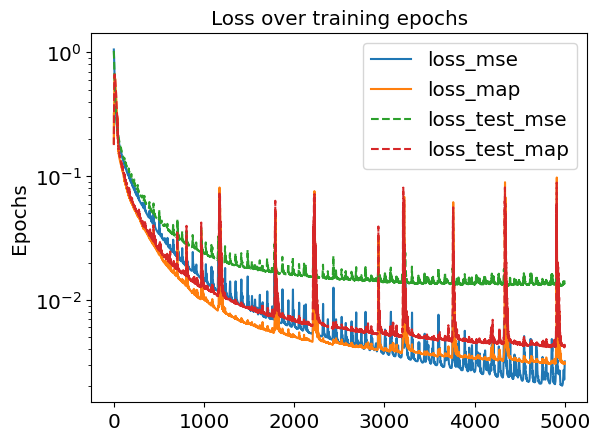

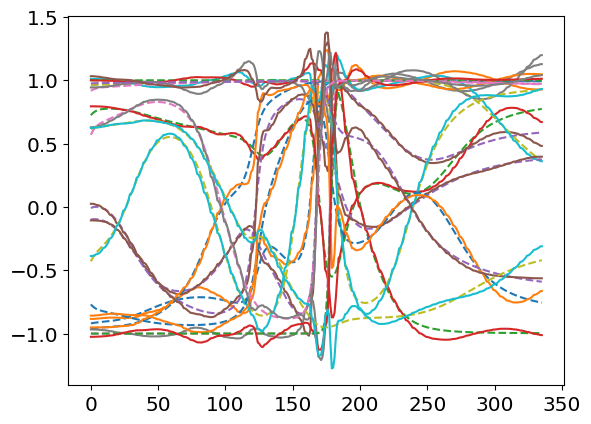

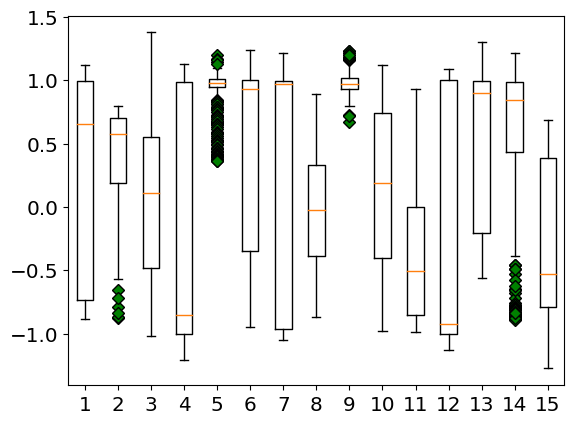

In [11]:
plotting.plot_loss(HyperParams)
plotting.plot_latent(HyperParams, latents_map, latents_gca)
#plotting.plot_error(results, VAR_all, scaler_all, HyperParams, mu_space, params, train_trajectories, vars)

N = 5
#snapshots = np.arange(params.shape[0]).tolist()
snapshots = np.arange(100).tolist() #sistemare
np.random.shuffle(snapshots)
for SNAP in snapshots[0:N]:
#for SNAP in np.arange(np.random.randint(0,326)).tolist():
    print(SNAP)
    #plotting.plot_fields(SNAP, results, scaler_all, HyperParams, dataset, xyz, params)
    #plotting.plot_error_fields(SNAP, results, VAR_all, scaler_all, HyperParams, dataset, xyz, params)

results_test, _, _ = testing.evaluate(VAR_test, model, val_loader, params, HyperParams, test_trajectories)

# Print the errors on the testing set

In [12]:
error_abs, norm = error.compute_error(results_test, VAR_test, scaler_test, HyperParams)
error.print_error(error_abs, norm, vars)
error.save_error(error_abs, norm, HyperParams, vars)


Maximum absolute error for field GCA-ROM =  50.52117363561725
Mean absolute error for field GCA-ROM =  28.466668913391846
Minimum absolute error for field GCA-ROM =  23.665226995219207

Maximum relative error for field GCA-ROM =  1.5812117681121307
Mean relative error for field GCA-ROM =  1.3791902077336053
Minimum relative error for field GCA-ROM =  1.3247747076108614


In [36]:
a = np.arange(9)
b = a.reshape(3,3)

N = 9
M = int(3) # to adjust
node_features_ary = np.zeros((int(N/3),3))
t = 0
for i in range(int(N/3)):
    for j in range(M):
        l = i+j+t-1
        node_features_ary[i,j] = a[l]
    t = t+1

In [37]:
a, b, node_features_ary

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]]),
 array([[8., 0., 1.],
        [1., 2., 3.],
        [3., 4., 5.]]))

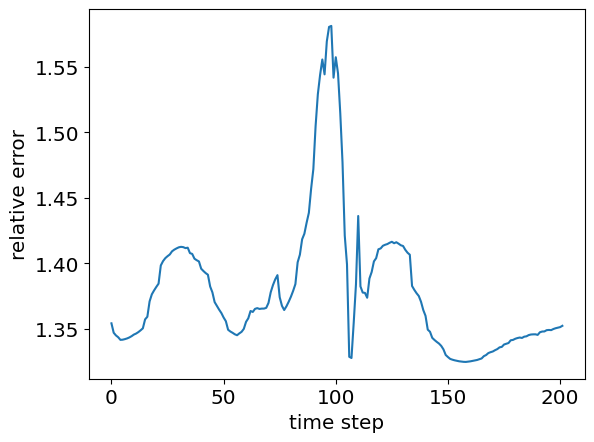

In [13]:

# when just one parameter
import matplotlib.pyplot as plt
plt.plot(np.array(error_abs)/np.array(norm))
plt.xlabel('time step')
plt.ylabel('relative error')
plt.show()